In [119]:
import pandas as pd
from pathlib import Path
from cmi_dss_lib.utils.metrics import event_detection_ap

from cmi_dss_lib.utils.post_process import post_process_for_seg
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use("ggplot")

RESULT_DIR = "../../../data/eda/predicted-fold0.npz"

In [121]:
data = np.load(RESULT_DIR)
keys = data["key"]
series_ids = list(set([str(k).split("_")[0] for k in keys]))
preds = data["pred"]
labels = data["label"]

gt_df = pd.read_csv(Path("../../../data/train-series-with-partid") / "train_events.csv")
gt_df = gt_df[gt_df["series_id"].isin(series_ids)].dropna().reset_index(drop=True)

In [136]:
def plot_random_sample(keys, preds, labels,df_submit, num_samples=1, num_chunks=5):
    # get series ids
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    unique_series_ids = np.unique(series_ids)

    # get random series
    random_series_ids = [unique_series_ids[0]]#np.random.choice(unique_series_ids, num_samples)

    for i, random_series_id in enumerate(random_series_ids):
        # get random series
        series_idx = np.where(series_ids == random_series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 3)
        this_series_labels = labels[series_idx].reshape(-1, 3)
        this_series_df = df_submit[df_submit["series_id"] == random_series_id].reset_index(drop = True)
        val_wakeup = this_series_df[this_series_df["event"] == "wakeup"]["step"].values
        val_onset = this_series_df[this_series_df["event"] == "onset"]["step"].values
        val_step = np.arange(1,preds[series_idx].reshape(-1,2).shape[0]+1)
        this_onset = np.isin(val_step,val_onset).astype(int)
        this_wakeup = np.isin(val_step,val_wakeup).astype(int)
        
        # split series
        this_series_preds = np.split(this_series_preds, num_chunks)
        this_series_wakeup = np.split(this_wakeup, num_chunks)
        this_series_onset = np.split(this_onset, num_chunks)
        this_series_labels = np.split(this_series_labels, num_chunks)

        fig, axs = plt.subplots(num_chunks, 1, figsize=(20, 5 * num_chunks))
        if num_chunks == 1:
            axs = [axs]
        for j in range(num_chunks):
            this_series_preds_chunk = this_series_preds[j]
            this_series_labels_chunk = this_series_labels[j]

            # get onset and wakeup idx
            onset_idx = np.nonzero(this_series_labels_chunk[:, 1])[0]*2
            wakeup_idx = np.nonzero(this_series_labels_chunk[:, 2])[0]*2

            pred_onset_idx = np.nonzero(this_series_onset[j])[0]
            pred_wakeup_idx = np.nonzero(this_series_wakeup[j])[0]
            

            #axs[j].plot(this_series_preds_chunk[:, 0], label="pred_sleep")
            #axs[j].plot(this_series_preds_chunk[:, 1], label="pred_onset")
            #axs[j].vlines(pred_onset_idx, 0, 1, label="pred_label_onset", linestyles="dotted", color="C1")
            #axs[j].vlines(onset_idx, 0, 1, label="actual_onset", linestyles="dashed", color="C1")
            axs[j].plot(this_series_preds_chunk[:, 2], label="pred_wakeup")
            axs[j].vlines(pred_wakeup_idx, 0, 1, label="pred_label_wakeup", linestyles="dotted", color="C4")
            axs[j].vlines(wakeup_idx, 0, 1, label="actual_wakeup", linestyles="dashed", color="C4",linewidth=4)

            axs[j].set_ylim(0, 1)
            axs[j].set_title(f"series_id: {random_series_id} chunk_id: {j}")
            axs[j].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()


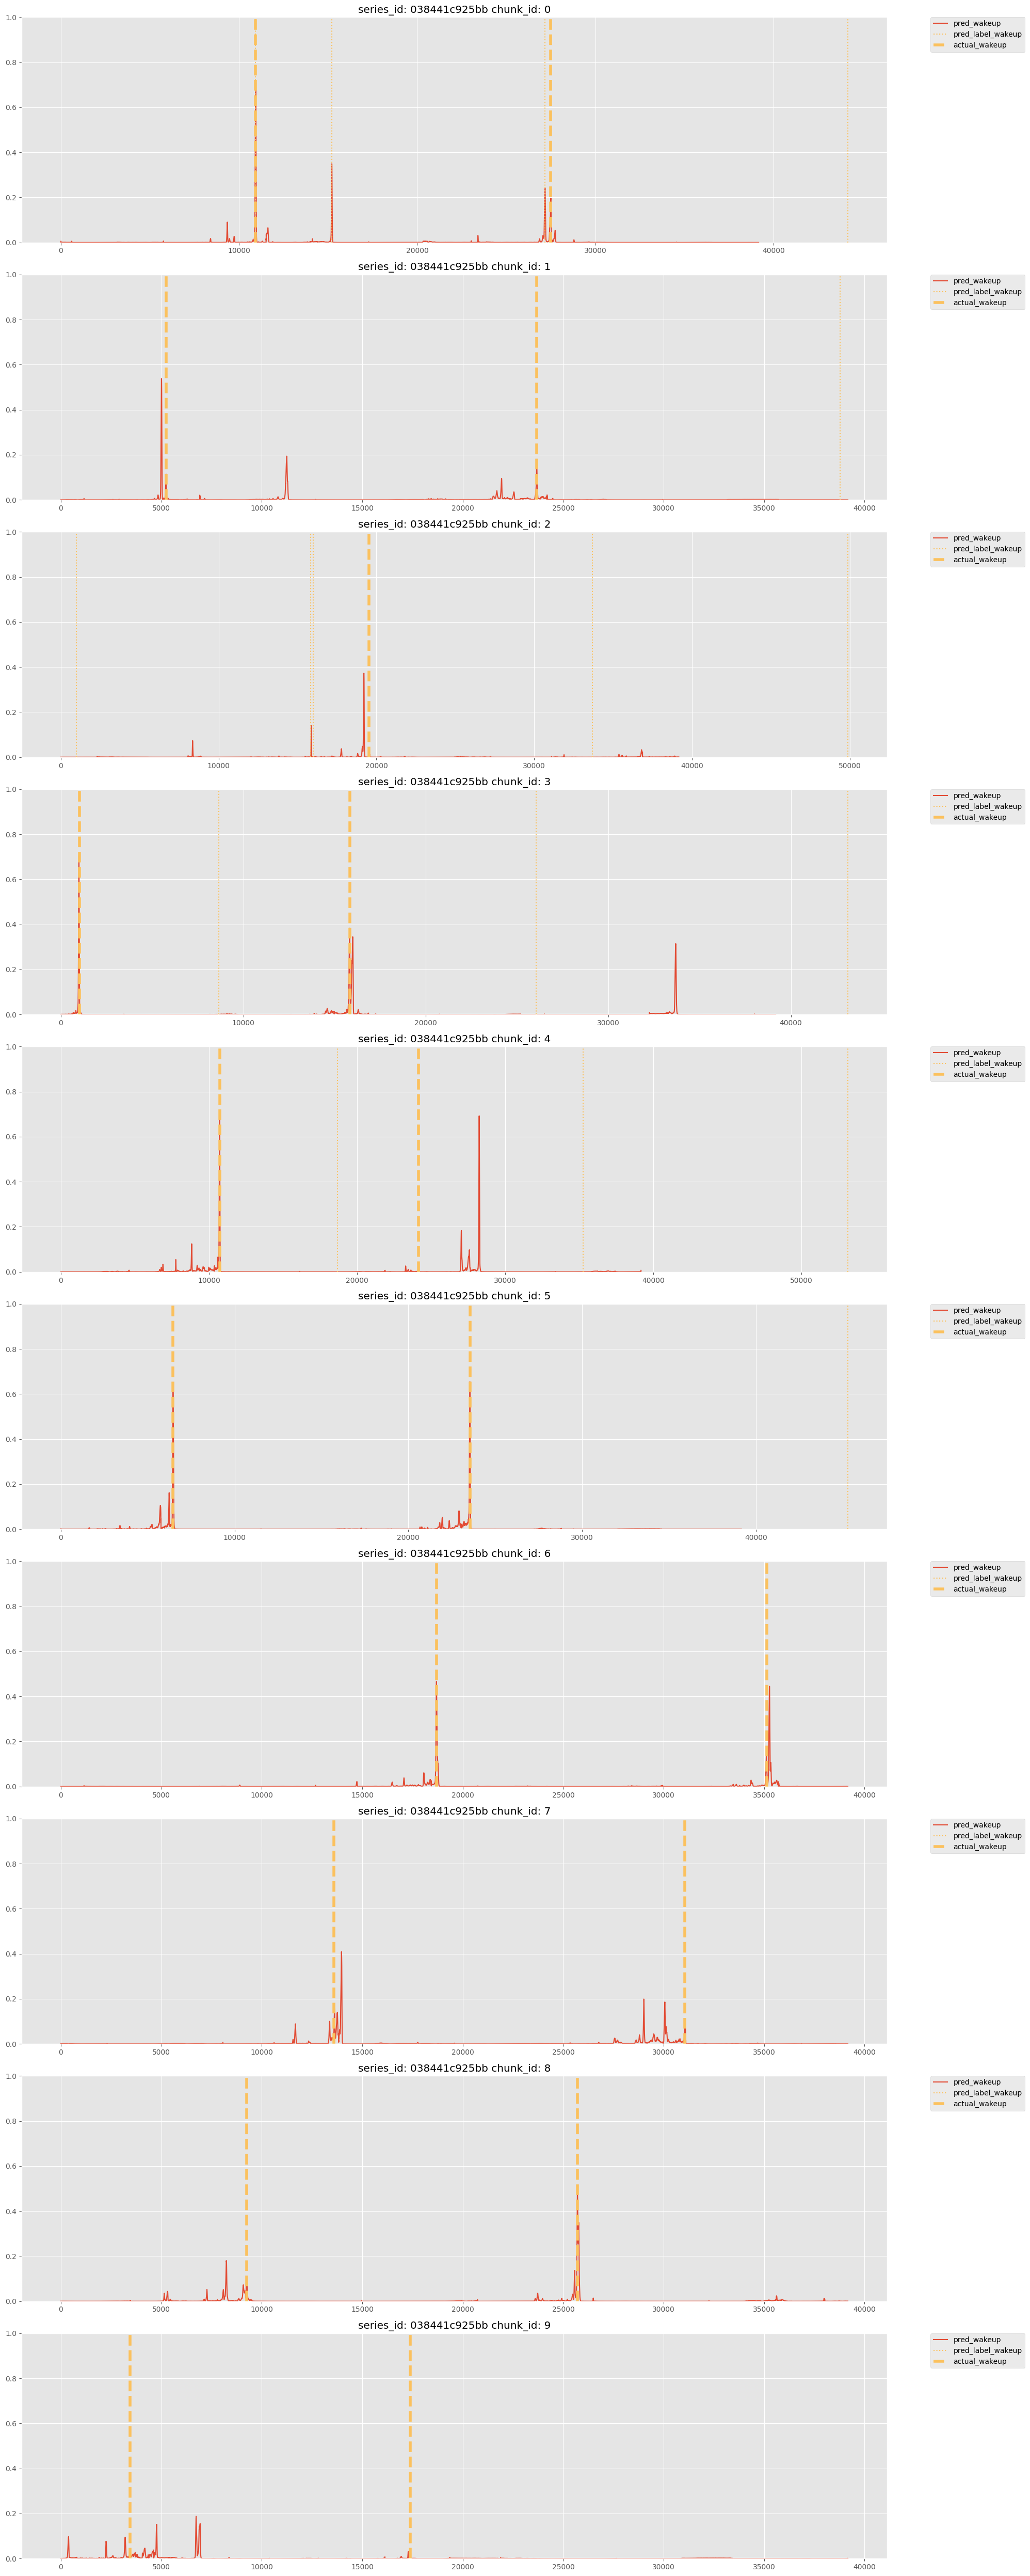

In [141]:
df_submit = post_process_for_seg(preds = preds[:,:,[1,2]] ,keys = keys,score_th=0.1,distance = 96).to_pandas()
plot_random_sample(keys, preds, labels,df_submit=df_submit, num_chunks=10)

In [142]:
event_detection_ap(solution=gt_df,submission=df_submit)

0.7251466117271206